# Minimal Demo

This notebook will use the small test data shapefiles to build a graph and find distances.

In [1]:
%load_ext autoreload
%autoreload 2
# the pylab line is just for the notebook
# it's not required elsewhere:
# https://stackoverflow.com/questions/20961287/what-is-pylab
%pylab inline
import pyriv
import os # used for file paths
import geopandas as gpd # for accessing shapefiles

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_dir = "../tests/testdata/"
fp = lambda s: os.path.join(data_dir, s)

In [3]:
land_fn = fp('CoastLine.shp')
rivers_fn = fp('Rivers.shp')
points_fn = fp('UpriverTestPoints.shp')

Load points to use as test locations.

In [4]:
test_points = gpd.read_file(points_fn)

## Simple Case

For this case we'll assume that all of our input data is perfect. All river dead ends are rivermouths, and the rivermouths are nodes on the coastline. First we'll work with just the rivers, and generate distances for a set of points up the rivers. 

Then, we'll generate a coastal network, join it to the river network, and calculated distances between points and a distance matrix for the full set up points.

## Build Directional River Network

Load a river shapefile, but don't load a coast shapefile. This will assume that all dead ends are rivermouths.

In [5]:
rivnet = pyriv.RiverGraph(data=rivers_fn)

Get the end points of the rivers, and display them along with the rivers edges and nodes as plotted by the Networkx `draw_networkx_edges` method. In this representation, the edges between nodes are shown as "arrows" (though the head of the arrow is just a wider line segment rather than a triangle) that indicate flow direction. The "arrow" segments are displayed as straight lines between nodes. However, the river geometry between nodes is preserved within the edge attributes as seen in the next representation.

/usr/local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/usr/local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


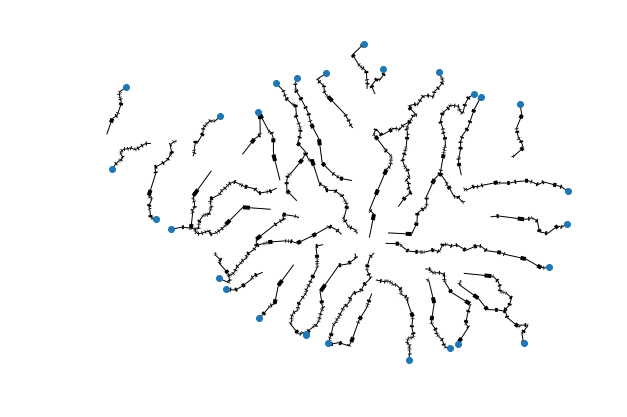

In [6]:
# get the river end points
riv_end_pnts = rivnet.deadend_gdf()
# plot the rivers and their end points
figsize(10,8)
ax = riv_end_pnts.plot(zorder=2)
rivnet.plot(ax=ax, zorder=1)
ax.set_axis_off()
# if you want to see this on a zoomable slippy map
# make sure mplleaflet is installed and uncomment 
# these lines
# import mplleaflet
# mplleaflet.display(epsg=3338)

Or, if you don't want to see the river nodes, simply use the `RiverGraph.summary_plot` method.

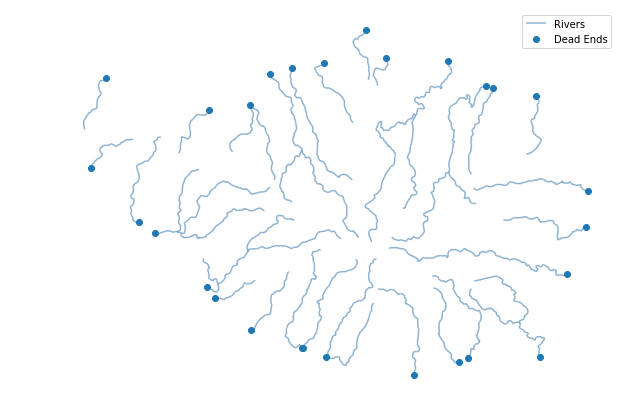

In [7]:
ax = rivnet.summary_plot()
legend() # pylab method for displaying legend.
ax.set_axis_off()

### Find Path to Ocean for 1 Point

Find the path from a point downstream to the deadend (presumably a rivermouth), and report the length (in meters - pyriv must be used with data in a projection with meters as the units). The `shortest_path_to_deadend` method takes a `RiverGraph` node (identified by it's position) as input to determine the starting node. So, for an arbitrary point that is not exactly on a node, we must use the `closest_node` method to convert the point to a starting node.

In [8]:
p0 = test_points.iloc[0].geometry
node0 = rivnet.closest_node(p0)
p0_path = rivnet.shortest_path_to_deadend(node0)
p0_path.length

18572.891085077586

Display the results graphically.

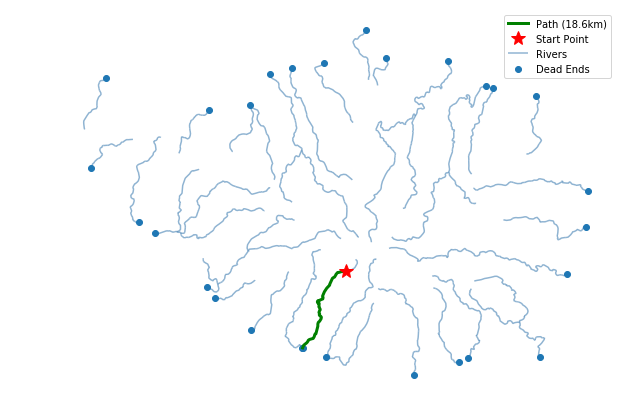

In [9]:
# plot the rivers and their end points
figsize(10,8)
ax = rivnet.summary_plot()
ax.set_axis_off()
# plot the path and start point
pthx, pthy = p0_path.xy
pthlbl = "Path ({:.1f}km)".format(p0_path.length * 1e-3)
ax.plot(pthx, pthy, c='g', zorder=2, linewidth=3, label=pthlbl)
ax.plot(*p0.xy, marker='*', markersize=15, c='r', 
        label='Start Point', linewidth=0)
foo = legend()

### Find Distances for All Test Points

For each point in the point shapefile referenced by the path `points_fn`, we'll find the path to the nearest dead end (assumed to be a rivermouth). The `pyriv.RiverGraph.river_distances` method returns a `pyriv.RiverDist` object which is really a `geopandas.GeoDataFrame` with a few extra methods and properties. The result for our test data contains 6 rows, but we'll just display the first 3 in tabular format.

In [10]:
rivgdf = rivnet.river_distances(points_fn)
rivgdf.head(3)

,id,geometry,path,rivdist_km,nearest_node,node_dist
0,1,POINT (-686159.3402290039 1176410.600136723),LINESTRING (-685865.8326982833 1176470.4243199...,18.572891,POINT (-685865.8326982833 1176470.424319983),299.542323
1,2,POINT (-682115.1922568978 1176121.732424429),LINESTRING (-682148.8606086159 1175861.2928523...,20.146047,POINT (-682148.8606086159 1175861.292852317),262.606795
2,3,POINT (-678107.1527488284 1173196.94683746),LINESTRING (-678159.8846274239 1173207.4960501...,19.569260,POINT (-678159.8846274239 1173207.496050171),53.776732


Plot a visual summary of the results.

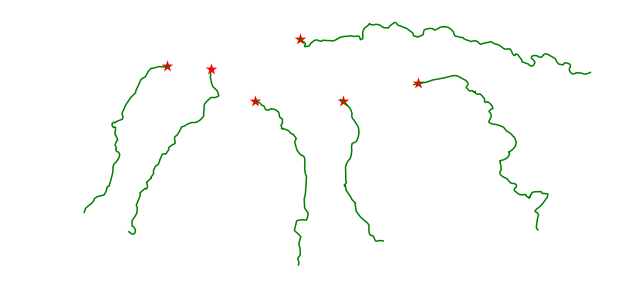

In [11]:
ax = rivgdf.summary_plot()
ax.set_axis_off()

Combine the river graph summary plot with the results summary plot.

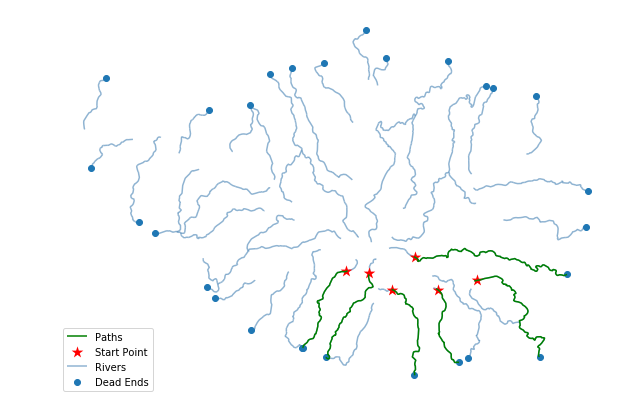

In [12]:
ax = rivgdf.summary_plot()
ax = rivnet.summary_plot(ax=ax)
legend(loc='lower left')
ax.set_axis_off()

## Build the Coastal Network

In [13]:
lnd = pyriv.Land.from_file(land_fn)

In [14]:
from shapely.geometry import Polygon

In [15]:
lnd.geom_type

0    LineString
1    LineString
2    LineString
3    LineString
4    LineString
5    LineString
6    LineString
7    LineString
8    LineString
dtype: object

In [16]:
lnd["first_coord"] = lnd.geometry.apply(lambda g: g.coords[0])
lnd["last_coord"] = lnd.geometry.apply(lambda g: g.coords[-1])
lnd["line_order"] = 0

In [17]:
first_coord = lambda g: g.coords[0]
last_coord = lambda g: g.coords[-1]

def is_circular(g):
    """
    Check a shapely Linestring geometry to see if it forms a closed loop.
    
    Parameters
    ----------
      g : a shapely.geometry.LineString
      
    Returns
    -------
      Bool
        True if the first coord equals the last coords, otherwise False.
    """
    return g.coords[0] == g.coords[-1]

def follows_id(row):
    fc = first_coord(row.geometry)
    return 

In [18]:
lnd["circ"] = lnd.geometry.apply(is_circular)
coord_series = lnd.query("circ == False").geometry.apply(lambda g: g.coords)
c1 = coord_series.iloc[0]

In [61]:
seg_list = list(coord_series)
def assemble_segs(s1, s2):
    if s1[-1] == s2[0]:
        seg = list(s1)
        seg.extend(list(s2))
    elif s1[0] == s2[-1]:
        seg = list(s2)
        seg.extend(list(s1))
    return seg
    
pnt_list = reduce(assemble_segs, seg_list)

In [100]:
from collections import deque

def assemble_segs(s1, s2):
    if s1[-1] == s2[0]:
        seg = list(s1)
        seg.extend(list(s2))
        return True, seg
    elif s1[0] == s2[-1]:
        seg = list(s2)
        seg.extend(list(s1))
        return True, seg
    else:
        return False, s1

seg_list = list(coord_series)
while len(seg_list) >= 2:
    print "hi"
    s1 = seg_list.pop()
    s2 = seg_list.pop()
    worked, s = assemble_segs(s1, s2)
    if worked:
        seg_list.append(s)
    else:
        seg_list.extend([s1, s2])


len(seg_list[0])


hi
hi


1241

In [95]:
foo

['pork', 'chop', 'sandwich', 'fart']

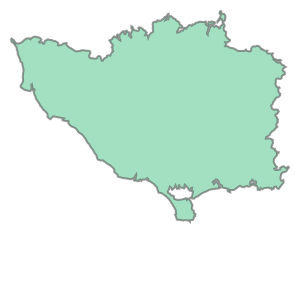

In [87]:
Polygon(pnt_list)

In [88]:
len(pnt_list), len(tuple(c0) + tuple(coord_series.iloc[2])  + tuple(coord_series.iloc[1]))

(1214, 1241)

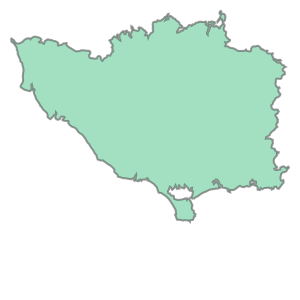

In [66]:
Polygon(tuple(c1) + tuple(coord_series.iloc[2])  + tuple(coord_series.iloc[1]))

In [68]:
g = lnd.geometry[0]

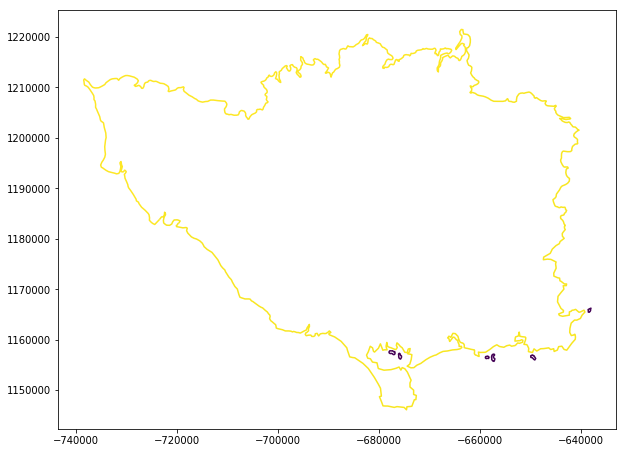

In [33]:
lnd.plot(column="Coastln010")

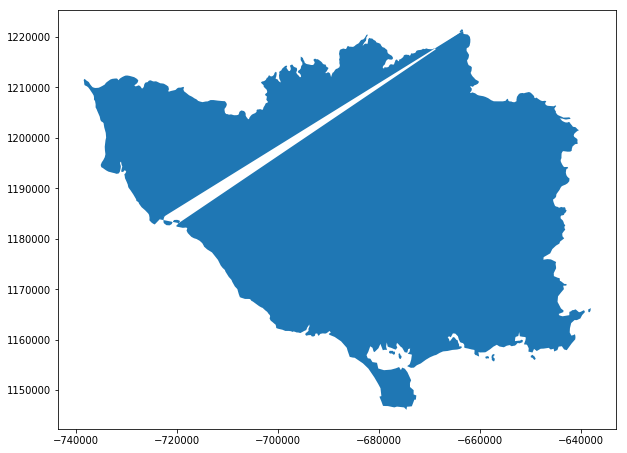

In [36]:
lnd.geometry.apply(lambda g: Polygon(g.coords)).plot()

In [31]:
lnd

,OBJECTID,Coastln010,Miles,SHAPE_Leng,geometry,first_coord,last_coord,line_order
0,241.0,2117,1.736284,0.034257,LINESTRING (-675697.1611079347 1156973.3228399...,"(-675697.161108, 1156973.32284)","(-675697.161108, 1156973.32284)",0
1,242.0,2118,2.085419,0.049607,LINESTRING (-677201.7004673904 1157764.1272520...,"(-677201.700467, 1157764.12725)","(-677201.700467, 1157764.12725)",0
2,243.0,2119,1.257900,0.029769,LINESTRING (-658152.6351434266 1156377.2897760...,"(-658152.635143, 1156377.28978)","(-658152.635143, 1156377.28978)",0
3,245.0,2121,2.331588,0.046613,LINESTRING (-657070.070150036 1155821.81389982...,"(-657070.07015, 1155821.8139)","(-657070.07015, 1155821.8139)",0
4,246.0,2122,1.922938,0.043805,LINESTRING (-649473.3598543869 1157026.4218245...,"(-649473.359854, 1157026.42182)","(-649473.359854, 1157026.42182)",0
5,1148.0,3025,127.352943,2.801531,LINESTRING (-723415.7591812038 1183863.5816668...,"(-723415.759181, 1183863.58167)","(-663304.299447, 1221180.1387)",0
6,248.0,2124,1.414257,0.028758,LINESTRING (-638141.2977923527 1165535.5365432...,"(-638141.297792, 1165535.53654)","(-638141.297792, 1165535.53654)",0
7,1138.0,3015,5.398531,0.112638,LINESTRING (-719637.5809855836 1183110.6407428...,"(-719637.580986, 1183110.64074)","(-723415.759181, 1183863.58167)",0
8,1139.0,3016,182.226136,4.177667,LINESTRING (-663304.2994474514 1221180.1386984...,"(-663304.299447, 1221180.1387)","(-719637.580986, 1183110.64074)",0
